In [6]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    cdi_mensal
"""

cdi = pd.read_sql_query(query, conn)

conn.close()



In [7]:
cdi['cdi'] = cdi['cdi'].str.replace(',', '.', regex=False).astype(float)

cdi['delta_cdi'] = cdi['cdi'].shift(-1) - cdi['cdi']
cdi['delta_cdi_lag_1'] = cdi['delta_cdi'].shift(1)
cdi['delta_cdi_lag_2'] = cdi['delta_cdi'].shift(2)

cdi = cdi.dropna(how='any', subset=['delta_cdi', 'delta_cdi_lag_1', 'delta_cdi_lag_2'])


In [8]:
import statsmodels.api as sm

X = cdi[['delta_cdi_lag_1', 'delta_cdi_lag_2']]
y = cdi['delta_cdi']

reg = sm.OLS(y, sm.add_constant(X)).fit()
results_reg = reg
print(results_reg.summary())

cdi_estimado = cdi[['data', 'cdi', 'delta_cdi']]
cdi_estimado['delta_cdi_estimado'] = results_reg.predict()
cdi_estimado['residuo'] = cdi_estimado['delta_cdi'] - cdi_estimado['delta_cdi_estimado']

                            OLS Regression Results                            
Dep. Variable:              delta_cdi   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     49.30
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           6.62e-18
Time:                        07:03:30   Log-Likelihood:                -69.243
No. Observations:                 189   AIC:                             144.5
Df Residuals:                     186   BIC:                             154.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0092      0.026     

/tmp/ipykernel_529655/2392937685.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdi_estimado['delta_cdi_estimado'] = results_reg.predict()
/tmp/ipykernel_529655/2392937685.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdi_estimado['residuo'] = cdi_estimado['delta_cdi'] - cdi_estimado['delta_cdi_estimado']


In [9]:
# GARCH
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

cdi_diff = cdi['cdi'].diff().dropna()
cdi_diff_pct = cdi_diff * 100

modelo_garch = arch_model(
    cdi_diff_pct,
    mean='constant',
    vol='Garch',
    p=1, q=1,
    dist='normal'
)

resultados_garch = modelo_garch.fit(disp='off')
print(resultados_garch.summary())

volatilidade_cdi = resultados_garch.conditional_volatility

cdi_estimado = cdi_estimado.join(volatilidade_cdi, how='inner')

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    cdi   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -937.537
Distribution:                  Normal   AIC:                           1883.07
Method:            Maximum Likelihood   BIC:                           1896.02
                                        No. Observations:                  188
Date:                Thu, Nov 06 2025   Df Residuals:                      187
Time:                        07:03:30   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.6327      2.793      0.585      0.559 [ -3.841,  7.10

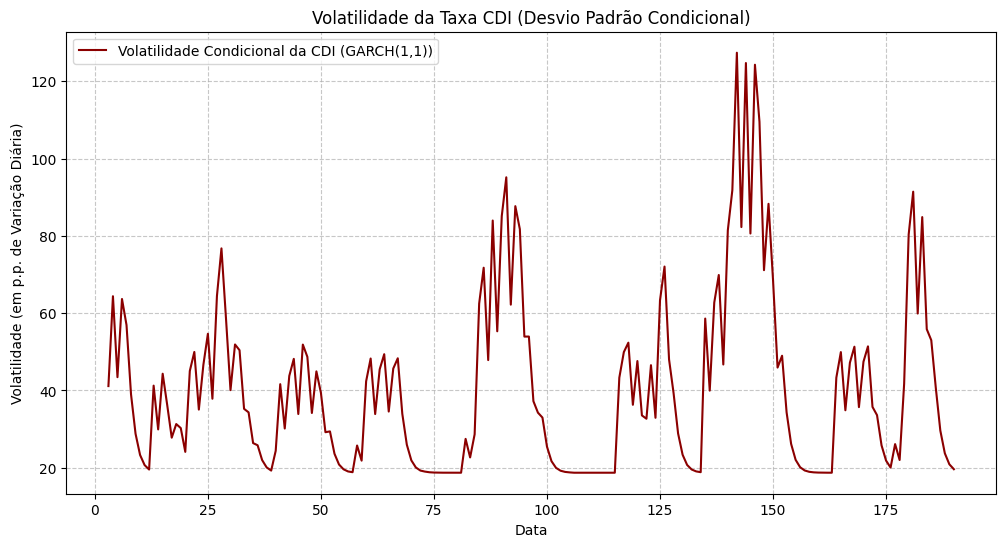

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(volatilidade_cdi, label='Volatilidade Condicional da CDI (GARCH(1,1))', color='darkred')
plt.title('Volatilidade da Taxa CDI (Desvio Padrão Condicional)')
plt.xlabel('Data')
plt.ylabel('Volatilidade (em p.p. de Variação Diária)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///dados/banking.db')

cdi_estimado.to_sql(
    'cdi_estimado',
    engine,
    if_exists='replace',
    index=False,
    chunksize=1000
)


188

Calculando volatilidade como taxas a termo

In [46]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    taxas_3meses
"""

taxas_3meses = pd.read_sql_query(query, conn)

conn.close()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

taxas_3meses['taxa'] = (taxas_3meses['taxa_t'] -1) *100
taxas_3meses_diff = taxas_3meses['taxa'].diff().dropna()
taxas_3meses_pct = taxas_3meses_diff * 100

modelo_garch = arch_model(
    taxas_3meses_pct,
    mean='constant',
    vol='Garch',
    p=1, q=1,
    dist='normal'
)

resultados_garch = modelo_garch.fit(disp='off')
print(resultados_garch.summary())

volatilidade_3m = resultados_garch.conditional_volatility

#cdi_estimado = cdi_estimado.join(volatilidade_3m, how='inner')

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   taxa   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13251.3
Distribution:                  Normal   AIC:                           26510.5
Method:            Maximum Likelihood   BIC:                           26536.6
                                        No. Observations:                 4983
Date:                Thu, Nov 06 2025   Df Residuals:                     4982
Time:                        07:57:46   Df Model:                            1
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -7.1423e-03  7.593e-02 -9.406e-02      0.925 [ -0.156,  

In [48]:
taxas_3meses['Data de Referência'] = pd.to_datetime(taxas_3meses['Data de Referência'])
taxas_3meses['data'] = taxas_3meses['Data de Referência'].dt.strftime('%Y-%m')

std = taxas_3meses.groupby(pd.Grouper(key='Data de Referência', freq='M'))['taxa'].agg(['std', 'mean'])
std.rename(columns={'std': 'std_3m', 'mean': 'mean_3m'}, inplace=True)


#cdi_estimado = cdi_estimado.join(volatilidade_cdi, how='inner')

/tmp/ipykernel_529655/2946544502.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  std = taxas_3meses.groupby(pd.Grouper(key='Data de Referência', freq='M'))['taxa'].agg(['std', 'mean'])


In [49]:
conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    taxas_1ano
"""

taxas_1ano = pd.read_sql_query(query, conn)

conn.close()

In [50]:
taxas_1ano['taxa'] = (taxas_1ano['taxa_t'] -1) *100
taxas_1ano_diff = taxas_1ano['taxa'].diff().dropna()
taxas_1ano_pct = taxas_1ano_diff * 100

modelo_garch = arch_model(
    taxas_1ano_pct,
    mean='constant',
    vol='Garch',
    p=1, q=1,
    dist='normal'
)

resultados_garch = modelo_garch.fit(disp='off')
print(resultados_garch.summary())

volatilidade_3m = resultados_garch.conditional_volatility


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   taxa   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -24294.8
Distribution:                  Normal   AIC:                           48597.6
Method:            Maximum Likelihood   BIC:                           48623.7
                                        No. Observations:                 4983
Date:                Thu, Nov 06 2025   Df Residuals:                     4982
Time:                        07:57:54   Df Model:                            1
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -5.9252e-03      1.081 -5.484e-03      0.996 [ -2.124,  

In [51]:
taxas_1ano['Data de Referência'] = pd.to_datetime(taxas_1ano['Data de Referência'])
taxas_1ano['data'] = taxas_1ano['Data de Referência'].dt.strftime('%Y-%m')

std_1ano = taxas_1ano.groupby(pd.Grouper(key='Data de Referência', freq='M'))['taxa'].agg(['std', 'mean'])
std_1ano.rename(columns={'std': 'std_1a', 'mean': 'mean_1a'}, inplace=True)

std = pd.merge(std, std_1ano,on=['Data de Referência'], how='left')

std = std.reset_index()

std.rename(columns={'Data de Referência': 'data'}, inplace=True)
std['data'] = std['data'].dt.strftime('%Y-%m')


/tmp/ipykernel_529655/2607980675.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  std_1ano = taxas_1ano.groupby(pd.Grouper(key='Data de Referência', freq='M'))['taxa'].agg(['std', 'mean'])


In [52]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///dados/banking.db')

std.to_sql(
    'std_taxas_termo',
    engine,
    if_exists='replace',
    index=False,
    chunksize=1000
)

240